In [1]:
from pathlib import Path
import numpy as np
import xarray as xr
import itertools
import warnings

import matplotlib.pyplot as plt
from matplotlib.collections import PathCollection
from matplotlib.legend_handler import HandlerPathCollection, HandlerLine2D

from kalman_reconstruction.kalman import (
    Kalman_SEM,
)
from reconstruct_climate_indices.idealized_ocean import (
    integrate_idealized_ocean,
)
from tqdm import tqdm

In [2]:
DATA_PATH = Path("../data/idealized_ocean/parameter_experiments")

PATH_FIGURES = Path("../results/figures/idealized_ocean_experiments")
SAVE_FIGURES = True


def save_fig(fig, relative_path, **kwargs):
    if SAVE_FIGURES:
        fig.savefig(PATH_FIGURES / relative_path, **kwargs)
    else:
        pass

In [3]:
plt.rcParams["figure.figsize"] = (10, 8)
# Set default matplotlib style
MEDIUM_SIZE = 12
BIGGER_SIZE = 15
HUGHER_SIZE = 18
plt.style.use("seaborn-v0_8-whitegrid")
# plt.style.use('dark_background')

plt.rcParams["figure.figsize"] = (10.0, 6.0)
plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
plt.rc("figure", titlesize=HUGHER_SIZE)  # fontsize of the axes title
plt.rc("figure", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc(
    "axes.spines",
    **dict(
        left=True,
        right=False,
        bottom=True,
        top=False,
    )
)
# fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("legend", loc="upper right")
# use colorblind save colors https://davidmathlogic.com/colorblind
colors = [
    "#CC6677",
    "#6E9CB3",
    "#CA8727",
    "#44AA99",
    "#AA4499",
    "#D6BE49",
    "#A494F5",
]
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=colors)


def plot_colors(colors):
    fig, axs = plt.subplots(figsize=(5, 1))
    for idx, color in enumerate(colors):
        axs.scatter(idx, 1, c=color, s=300)

    axs.set_yticks([])
    return fig, axs

In [4]:
def product_dict(**kwargs):
    keys = kwargs.keys()
    for instance in itertools.product(*kwargs.values()):
        yield dict(zip(keys, instance))

In [5]:
default_settings = dict(
    time_steps = 1000, 
    dt = 365.25,
    stochastic_forcing_intensity = 1.15e-1,
    ocean_restoring_timescale = 10 * 365.25,
    ocean_oscillation_timescale = 24 * 365.25,
    save_path = None,
)

time = np.arange(default_settings["time_steps"]) * default_settings["dt"]

var_names = [
 'surface_air_temperature',
 'sponge_sea_surface_temperature',
 'oscillator_sea_surface_temperature',
 'oscillator_deep_ocean_temperature',
]

In [6]:
factor = np.array([[0.1], [0.5], [1], [5], [10]])
experiment_settings = dict() 
experiment_settings_flat = dict() 
for key in ["stochastic_forcing_intensity", "ocean_restoring_timescale", "ocean_oscillation_timescale"] :
    experiment_settings[key] = default_settings[key] * factor
    experiment_settings_flat[key] = default_settings[key] * factor.flatten()

coords_data_set = {"time": time, **experiment_settings_flat}    

data_exp = xr.Dataset(coords=coords_data_set)
for var_name in var_names:
    data_exp[var_name] = xr.DataArray(
            data=np.nan,
            dims=coords_data_set.keys(),
            coords=coords_data_set
        )
data_exp

<xarray.Dataset>
Dimensions:                             (time: 1000,
                                         stochastic_forcing_intensity: 5,
                                         ocean_restoring_timescale: 5,
                                         ocean_oscillation_timescale: 5)
Coordinates:
  * time                                (time) float64 0.0 365.2 ... 3.649e+05
  * stochastic_forcing_intensity        (stochastic_forcing_intensity) float64 ...
  * ocean_restoring_timescale           (ocean_restoring_timescale) float64 3...
  * ocean_oscillation_timescale         (ocean_oscillation_timescale) float64 ...
Data variables:
    surface_air_temperature             (time, stochastic_forcing_intensity, ocean_restoring_timescale, ocean_oscillation_timescale) float64 ...
    sponge_sea_surface_temperature      (time, stochastic_forcing_intensity, ocean_restoring_timescale, ocean_oscillation_timescale) float64 ...
    oscillator_sea_surface_temperature  (time, stochastic_forcing_intensity, ocean_restoring_timescale, ocean_oscillation_timescale) float64 ...
    oscillator_deep_ocean_temperature   (time, stochastic_forcing_intensity, ocean_restoring_timescale, ocean_oscillation_timescale) float64 ...

In [7]:
product_experiment_settings = list(product_dict(**experiment_settings))
product_experiment_settings_flat = list(product_dict(**experiment_settings_flat))
for elem, elem_flat in zip(
    product_experiment_settings,
    product_experiment_settings_flat,
    ) :
    current_settings = {**default_settings, **elem}
    data_exp.loc[elem_flat] = integrate_idealized_ocean(**current_settings).expand_dims(dim=elem).assign_coords(elem).loc[elem_flat]

# store the integration file
data_exp.to_netcdf(DATA_PATH / "integrations.nc")

C:\Users\Niebaum\Documents\Repositories\reconstruct-climate-indices\reconstruct_climate_indices\idealized_ocean.py:86: RuntimeWarning: overflow encountered in multiply
  DOT_osc[it] = DOT_osc[it - 1] + (o0 * SST_osc[it - 1]) * dt
C:\Users\Niebaum\Documents\Repositories\reconstruct-climate-indices\reconstruct_climate_indices\idealized_ocean.py:83: RuntimeWarning: invalid value encountered in subtract
  + (-l0 * SST_osc[it - 1] - o0 * DOT_osc[it - 1]) * dt
C:\Users\Niebaum\Documents\Repositories\reconstruct-climate-indices\reconstruct_climate_indices\idealized_ocean.py:86: RuntimeWarning: invalid value encountered in add
  DOT_osc[it] = DOT_osc[it - 1] + (o0 * SST_osc[it - 1]) * dt
C:\Users\Niebaum\Documents\Repositories\reconstruct-climate-indices\reconstruct_climate_indices\idealized_ocean.py:82: RuntimeWarning: overflow encountered in add
  SST_osc[it - 1]
C:\Users\Niebaum\Documents\Repositories\reconstruct-climate-indices\reconstruct_climate_indices\idealized_ocean.py:82: RuntimeWarn

Add masking to make sure only combinations of arguments are used which give reasonable results.

In [8]:
VALUE_MAX = 10e3

i = 0
for key in [
    # "surface_air_temperature",
    # "sponge_sea_surface_temperature",
    # "oscillator_sea_surface_temperature",
    "oscillator_deep_ocean_temperature",
    ] :
    if i == 0 :
        coverage = data_exp[key].isnull().sum("time")
        mean_to_high = (np.abs((data_exp[key])) > VALUE_MAX).sum("time")
    else : 
        coverage += data_exp[key].isnull().sum("time")
        mean_to_high += (np.abs((data_exp[key])) > VALUE_MAX).sum("time")
    i += 1
data_exp["mask"] = (coverage + mean_to_high) == 0

# replace all not valid values by np.NaN
data_exp = data_exp.where(data_exp.mask)

Add random variable to be used for all kalman usages.

In [9]:
# make sure to get a kind of random seed
seed = np.random.default_rng(seed=2349832653).integers(0, 1e12, 1)
variance_unobs_comp = 1
random_generator = np.random.default_rng(seed=seed)
random_variable = random_generator.normal(loc=0, scale=variance_unobs_comp, size=len(data_exp.time))
data_exp["random_variable"]=(['time'],  random_variable)


Check that the random variable is not correlated to the surface air temperature

In [10]:
print("Maximum correlation coefficient of random variable to:")
for var_name in var_names:
    correlation = np.max(np.abs(xr.corr(data_exp[var_name], data_exp.random_variable, dim="time")))
    print(f"{var_name} : {correlation.values:.3f}")

Maximum correlation coefficient of random variable to:
surface_air_temperature : 0.009
sponge_sea_surface_temperature : 0.066
oscillator_sea_surface_temperature : 0.054
oscillator_deep_ocean_temperature : 0.067


In [11]:
# store the final integration file
data_exp.to_netcdf(DATA_PATH / "integrations.nc")

Code to run the Kalman Itteration for all experiments

In [12]:
# variance of the random white noise of z
variance_unobs_comp = 1

# variance of the observation error used in Kalman
variance_obs_comp = 0.0001

# number of SEM iterations
nb_iter_SEM = 30

Create Dataset for kalman_results

In [13]:
data_kalman_oscillator = xr.Dataset({})
store = ["surface_air_temperature", "oscillator_sea_surface_temperature", "random_variable"]
kalman_result_names = ["kalman_state", "kalman_prob", "kalman_loglike"]
for key in store[:] + ["random_variable"]:
    for krn in kalman_result_names:
        var_name = f"{krn}_{key}"
        data_kalman_oscillator[var_name] = xr.DataArray(coords=data_exp.coords)


In [14]:
iteration_per_second = 2
iterations = 1 * np.size(data_exp.mask) * nb_iter_SEM
print(f"expected duration = {iterations / iteration_per_second / 60} min")

expected duration = 31.25 min


In [15]:
data_loaded = False
try :
    data_kalman_oscillator = xr.open_dataset(DATA_PATH /  "data_kalman_oscillator.nc")
    data_loaded = True
except Exception as E :
    print(E)
    

In [16]:
def run_Kalman_SEM(y0,y1,z1):
    # state
    y = np.array([y0, y1]).T
    x = np.array([y0, y1, z1]).T

    # shapes
    n = np.shape(x)[1]
    p = np.shape(y)[1]

    # kalman parameters
    H = np.append(np.eye(p), np.zeros((p,p)), axis = 1)[:,0:n]
    R = variance_obs_comp * np.eye(p)

    # stochastic EM
    return  Kalman_SEM(x, y, H, R, nb_iter_SEM)

store = ["surface_air_temperature", "oscillator_sea_surface_temperature", "random_variable"]
kalman_result_names = ["kalman_state", "kalman_prob", "kalman_loglike"]


pbar_exp = tqdm(product_experiment_settings_flat)
pbar_exp.set_description("Total progres")

"""!!!!!!!!! Only run if the data is not loaded yet !!!!!!!!!"""
if data_loaded is False :
    for select_dict in pbar_exp :
        if data_exp.mask.sel(select_dict).values in [True, 1]:
            y0 = data_exp["surface_air_temperature"].sel(select_dict).values.flatten()
            y1 = data_exp["oscillator_sea_surface_temperature"].sel(select_dict).values.flatten()
            z1 = data_exp.random_variable
            try : 
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")
                    kalman_state, kalman_prob, M, kalman_loglik, x, x_f, Q = run_Kalman_SEM(y0, y1, z1)
                
                # Store the results in the array
                for key, idx in zip(
                        store,
                        range(len(kalman_state))
                        ):
                    for krn, data_to_store in zip(
                        kalman_result_names,
                        [kalman_state, kalman_prob, kalman_loglik]
                        ):

                        var_name = f"{krn}_{key}"
                        if np.ndim(data_to_store) == 2:
                            data_kalman_oscillator[var_name].loc[select_dict] = xr.DataArray(
                                data=data_to_store[:,idx],
                                dims=["time"],
                                coords=dict(
                                time=data_kalman_oscillator.time,
                                ),
                            )

                        elif np.ndim(data_to_store) == 3:
                            data_kalman_oscillator[var_name].loc[select_dict] = xr.DataArray(
                                data=data_to_store[:,idx, idx],
                                dims=["time"],
                                coords=dict(
                                time=data_kalman_oscillator.time,
                                ),
                            )
                        else : 
                            pass
            except Exception as exep:
                pass
                print(f"Error during kalman: \n{list(select_dict.values())}\n{exep}\n")
        else :
            print(f"Invalid integration: \n{list(select_dict.values())}\n")
        # data_kalman_oscillator.to_netcdf(DATA_PATH / "data_kalman_oscillator.nc", mode = "a")

Total progres:   0%|          | 0/125 [00:00<?, ?it/s]

In [17]:
data_kalman_oscillator["correlation_coef"] = xr.corr(
    data_exp.oscillator_deep_ocean_temperature, 
    data_kalman_oscillator.kalman_state_random_variable,
    dim="time"
    )

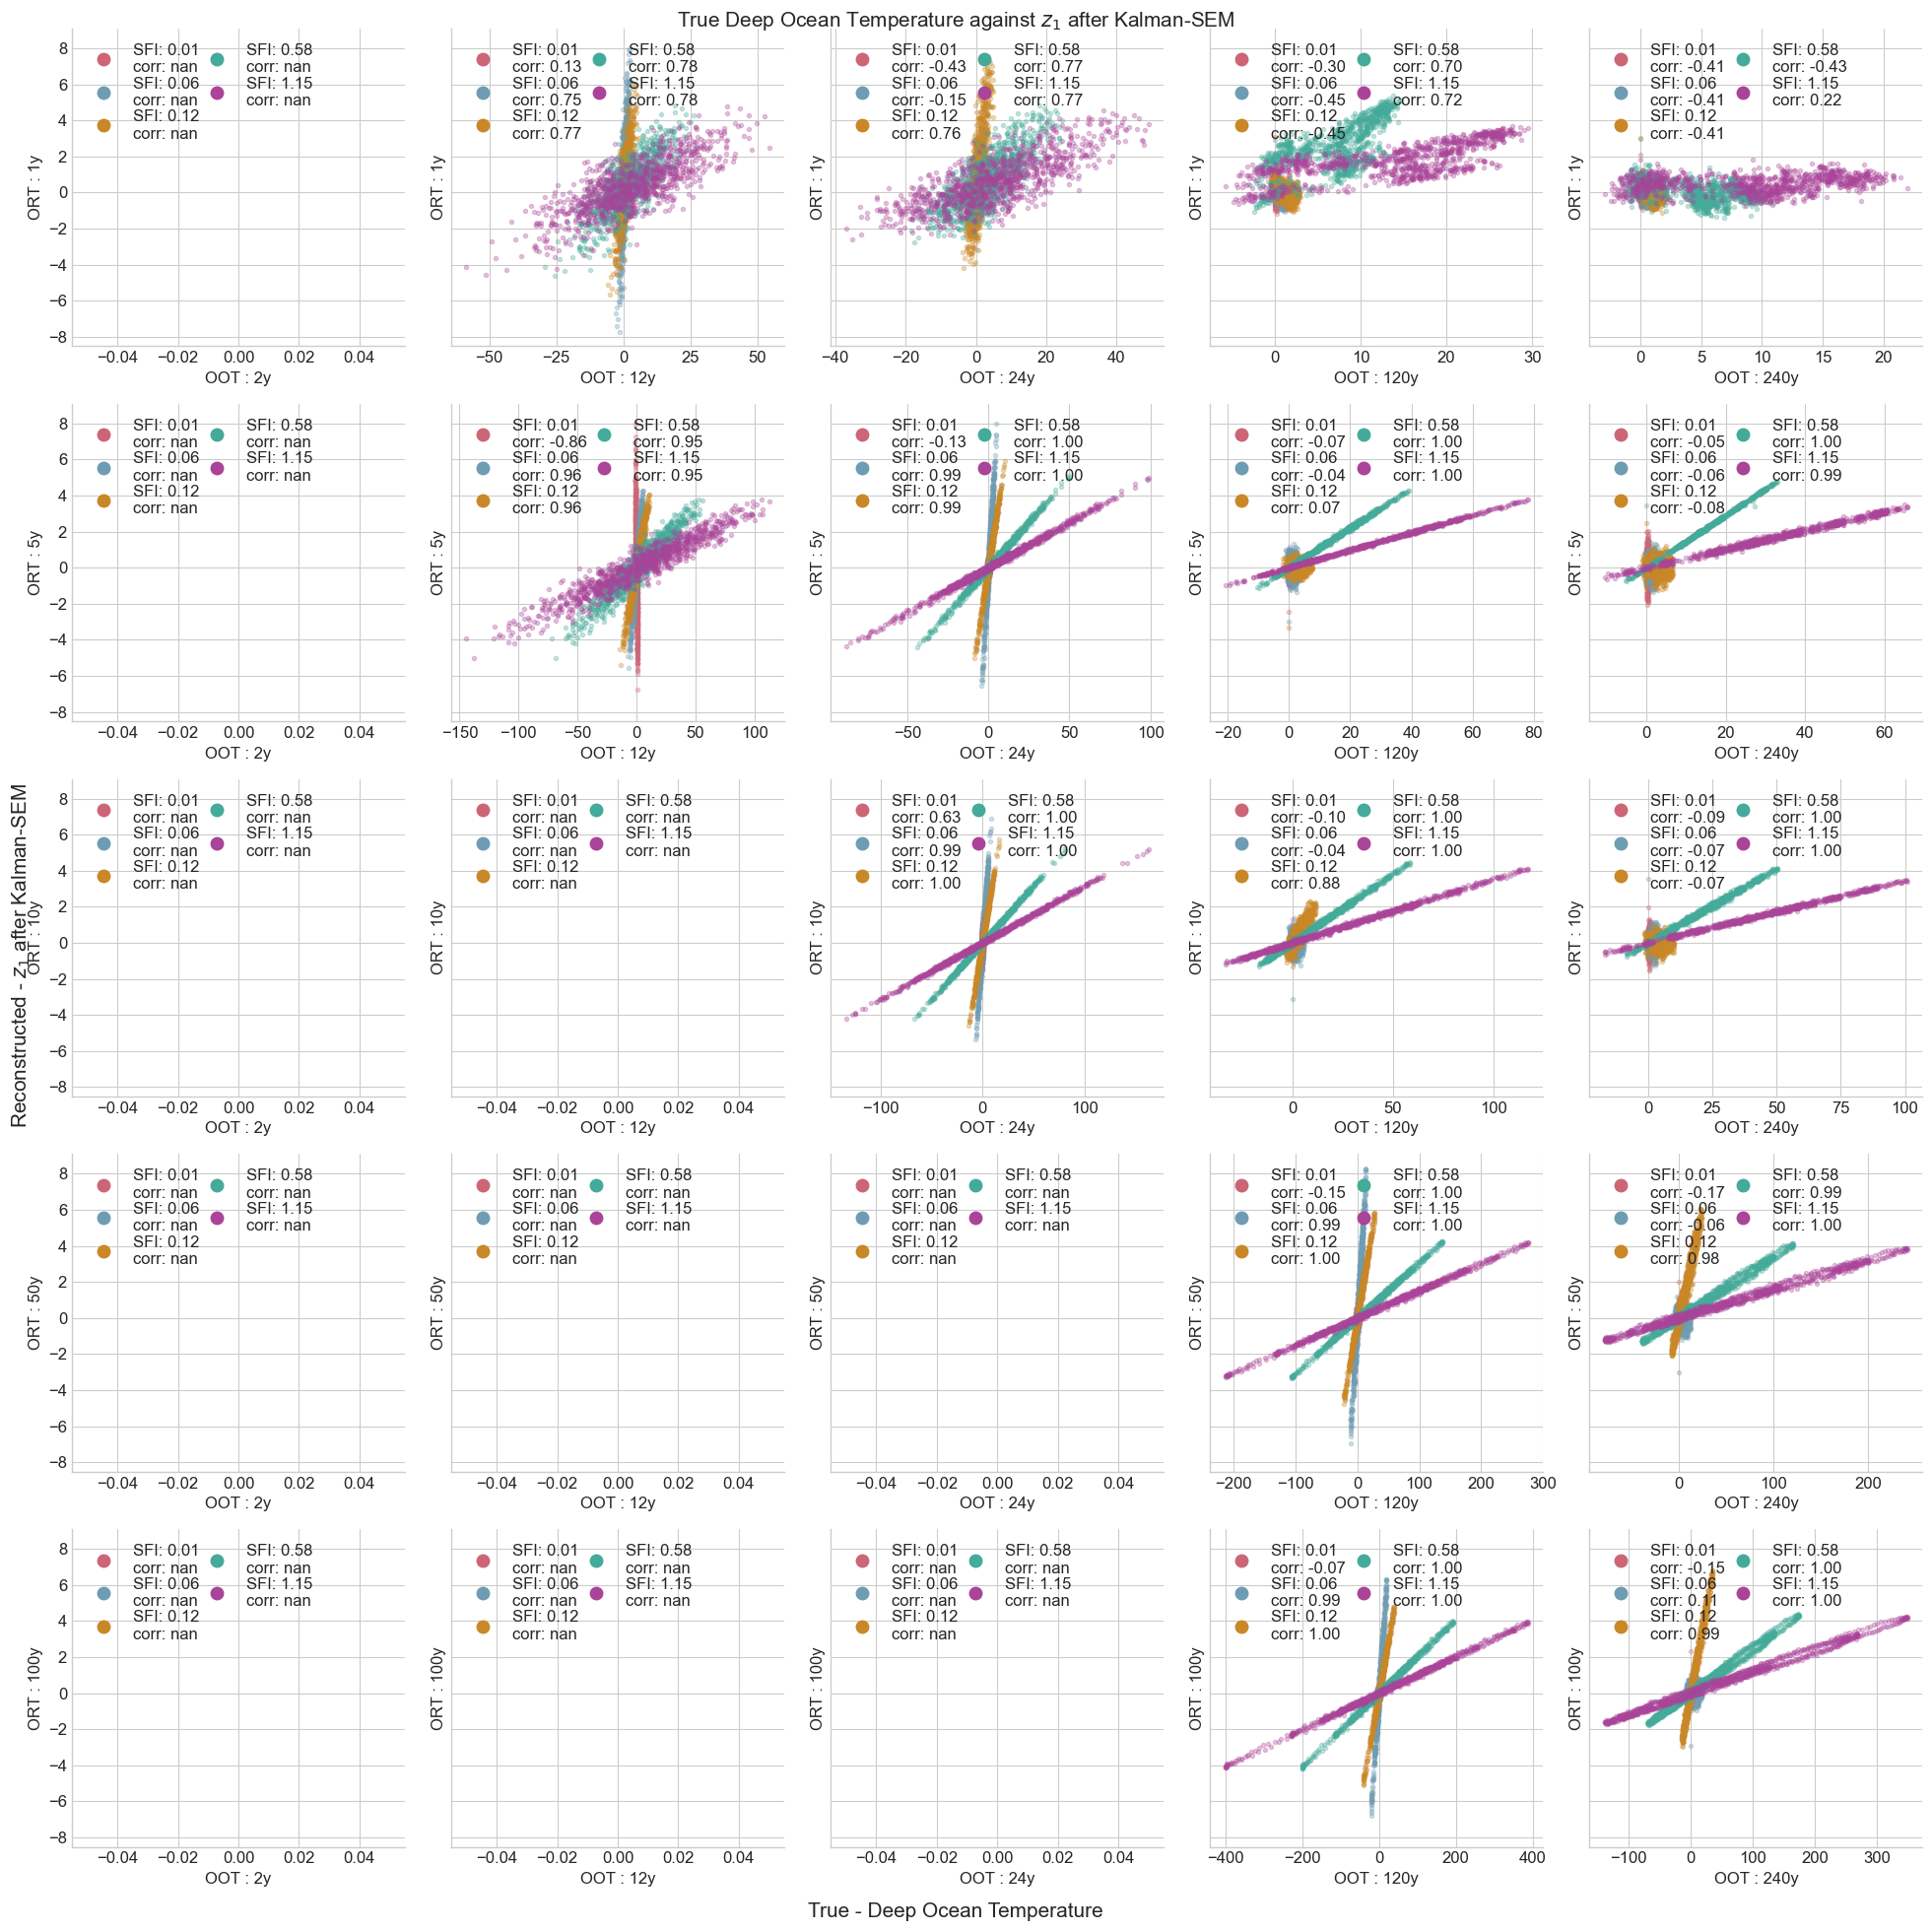

In [18]:
kwargs = dict(
    linewidth=None,
    linestyle="",
    alpha=0.3,
    marker=".",
)


x_labels = data_kalman_oscillator.ocean_oscillation_timescale.values
y_labels = data_kalman_oscillator.ocean_restoring_timescale.values
color_labels = data_kalman_oscillator.stochastic_forcing_intensity.values



fig, axs = plt.subplots(ncols=len(x_labels), nrows=len(y_labels), figsize=(20, 20), sharey=True, sharex=False)
for x_idx, x_value in enumerate(x_labels) :
    for y_idx, y_value in enumerate(y_labels) :
        for c_value in color_labels :
            sub = dict(
                ocean_oscillation_timescale = x_value,
                ocean_restoring_timescale = y_value,
                stochastic_forcing_intensity = c_value,
            )
            axs[y_idx, x_idx].plot(
                data_exp.oscillator_deep_ocean_temperature.sel(sub), 
                data_kalman_oscillator.kalman_state_random_variable.sel(sub),
                label = f"SFI: {c_value:.2f}\ncorr: {data_kalman_oscillator.correlation_coef.sel(sub).values:.2f}", 
                **kwargs,
            )
        # axs[y_idx, x_idx].set_title(f"OOT: {x_labels[idx] / 365.25:.0f}y" + f"\nORT: {y_labels[idx] / 365.25:.0f}y")
        axs[y_idx, x_idx].set_xlabel(f"OOT : {x_labels[x_idx] / 365.25:.0f}y")
        axs[y_idx, x_idx].set_ylabel(f"ORT : {y_labels[y_idx] / 365.25:.0f}y")
        
# for idx in range(len(axs)) :
#     axs[-1, idx].set_xlabel(f"OOT : {x_labels[idx] / 365.25:.0f}y")
#     axs[idx, 0].set_ylabel(f"ORT : {y_labels[idx] / 365.25:.0f}y")

def update(handle, orig):
    # https://stackoverflow.com/a/59629242/16372843
    handle.update_from(orig)
    handle.set_alpha(1)

for ax in axs.flatten() :
    ax.legend(
        loc="upper left",
        ncol=2, 
        markerfirst=True,
        markerscale = 3,
        scatterpoints = 1,
        labelspacing = 0.07,
        columnspacing = 0.07,
        handler_map={PathCollection : HandlerPathCollection(update_func= update),
                        plt.Line2D : HandlerLine2D(update_func = update)}
        )
fig.suptitle(r"True Deep Ocean Temperature against $z_1$ after Kalman-SEM")
fig.supxlabel("True - Deep Ocean Temperature")
fig.supylabel("Reconstructed - $z_1$ after Kalman-SEM")
fig.tight_layout()
fig.savefig("Experiments_correlation.png", dpi = 400)

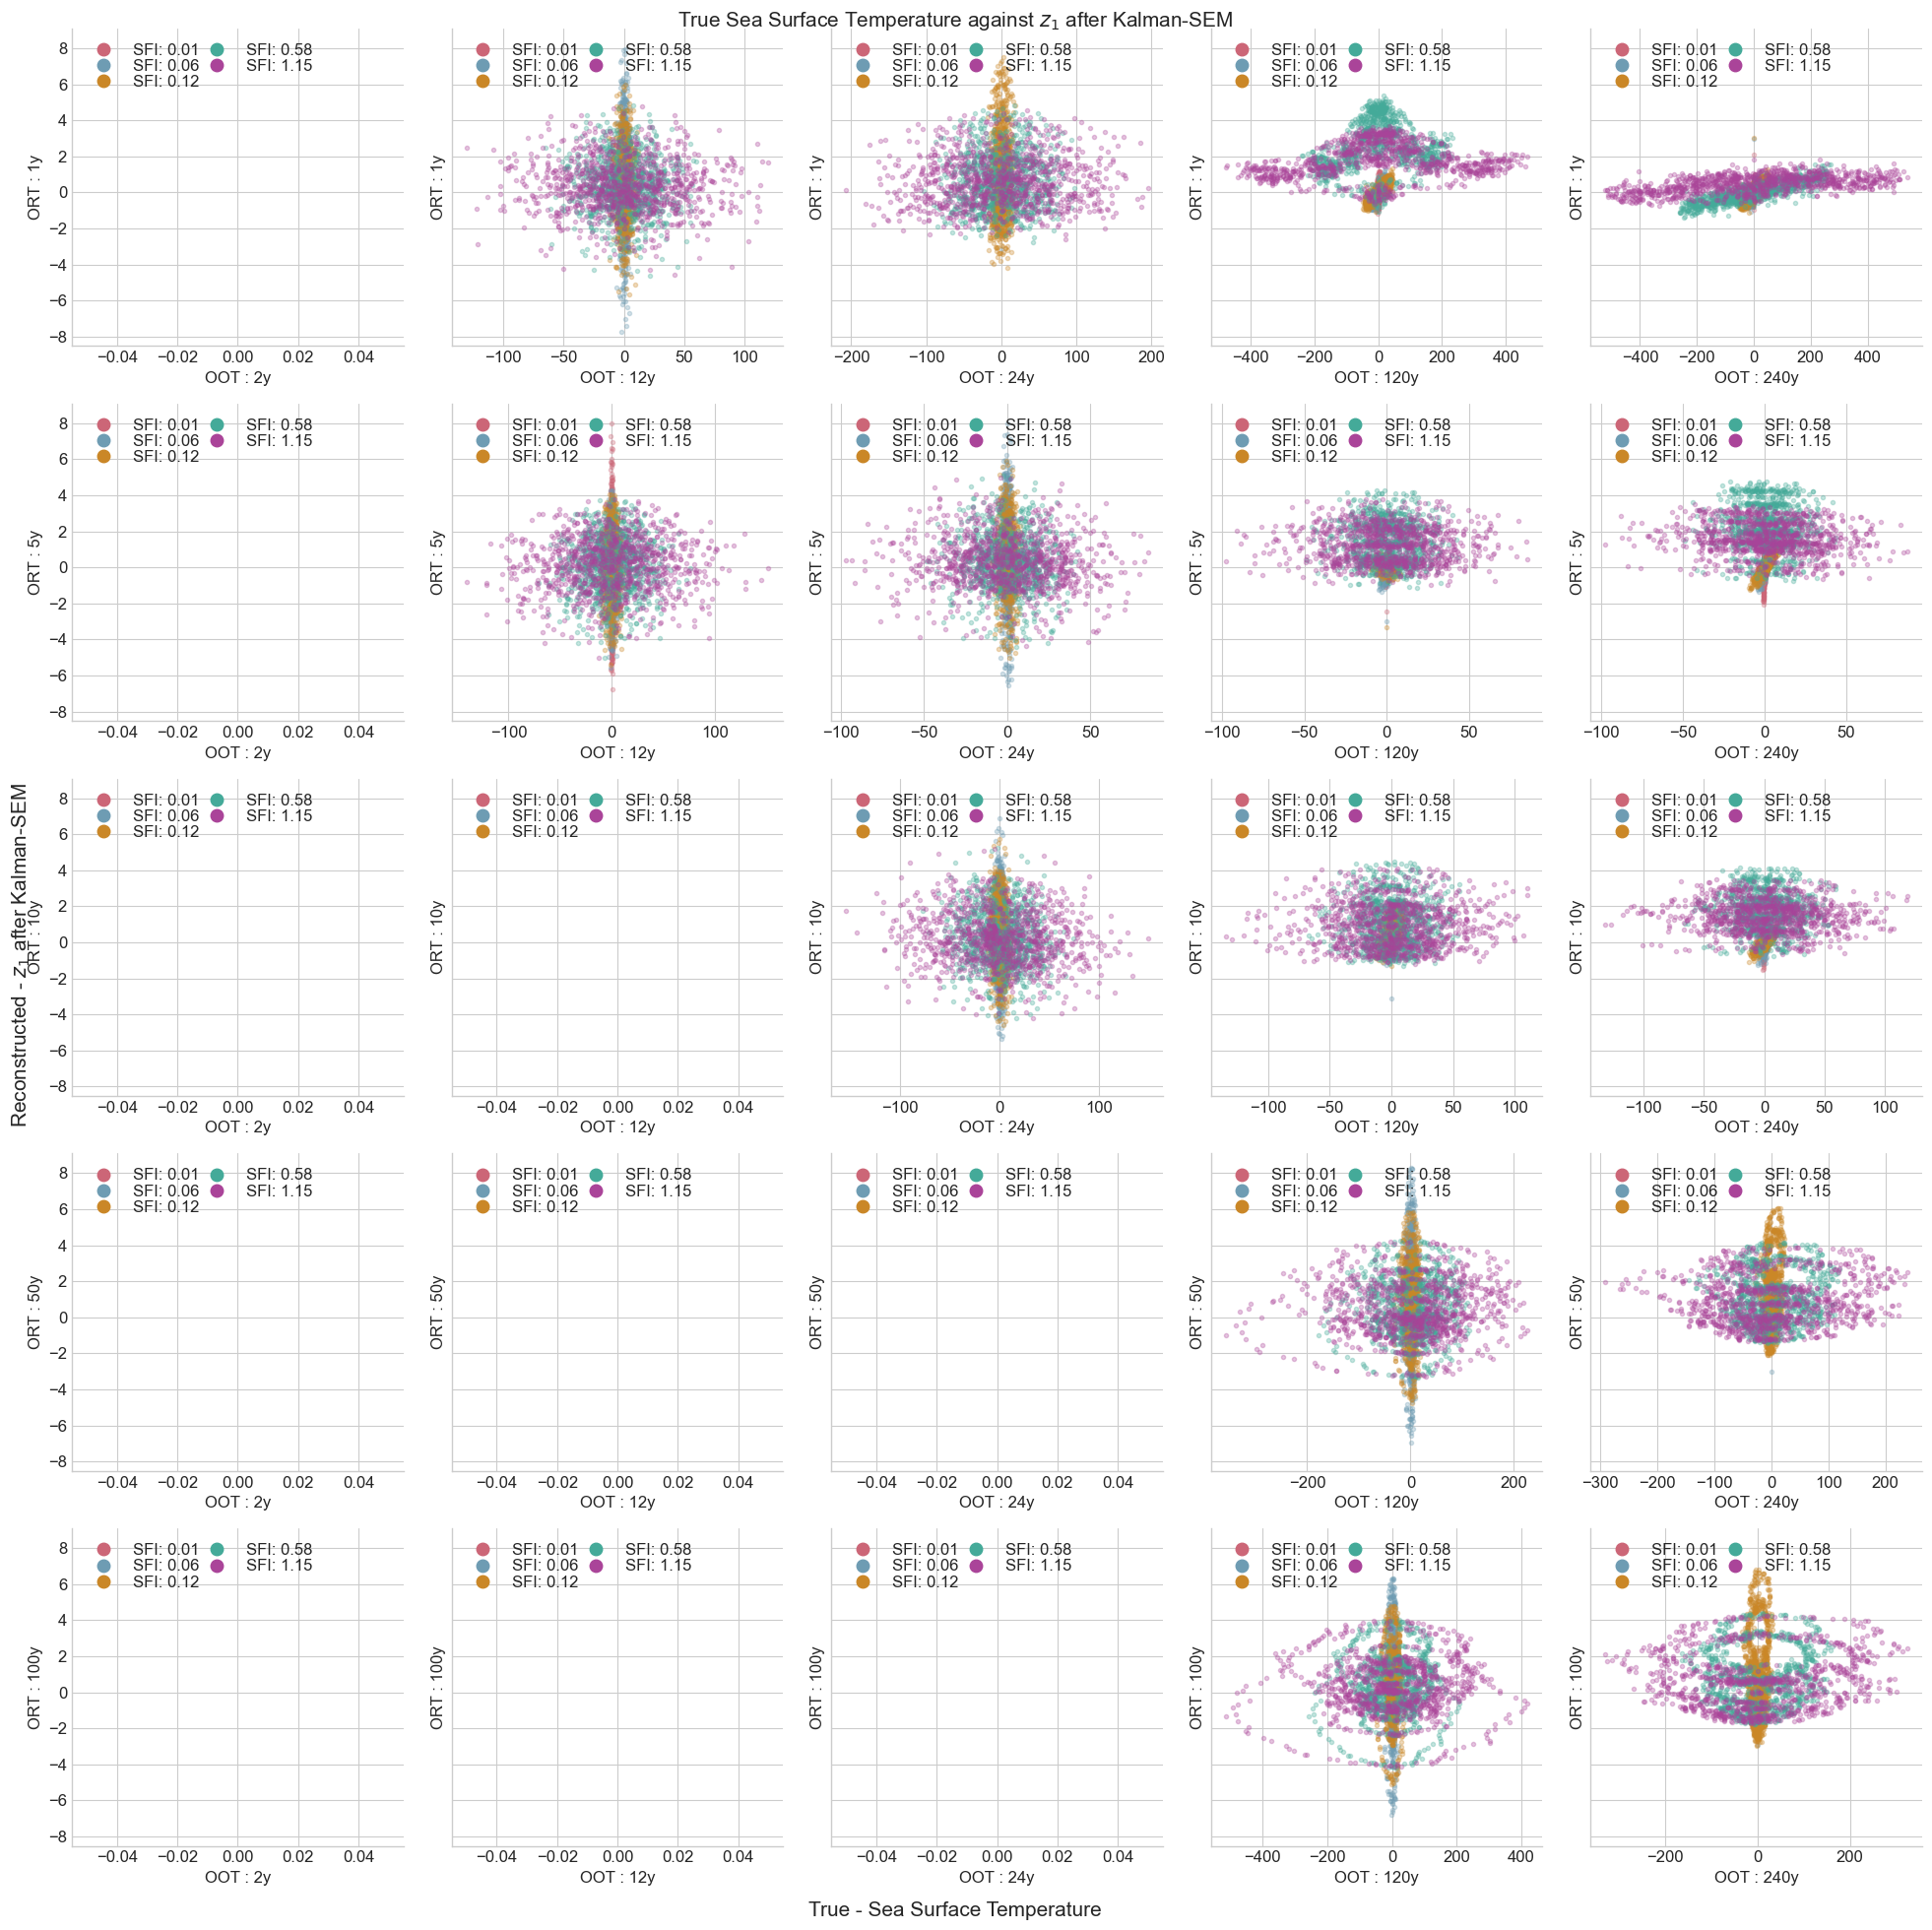

In [19]:
kwargs = dict(
    linewidth=None,
    linestyle="",
    alpha=0.3,
    marker=".",
)


x_labels = data_kalman_oscillator.ocean_oscillation_timescale.values
y_labels = data_kalman_oscillator.ocean_restoring_timescale.values
color_labels = data_kalman_oscillator.stochastic_forcing_intensity.values



fig2, axs = plt.subplots(ncols=len(x_labels), nrows=len(y_labels), figsize=(20, 20), sharey=True, sharex=False)
for x_idx, x_value in enumerate(x_labels) :
    for y_idx, y_value in enumerate(y_labels) :
        for c_value in color_labels :
            sub = dict(
                ocean_oscillation_timescale = x_value,
                ocean_restoring_timescale = y_value,
                stochastic_forcing_intensity = c_value,
            )
            axs[y_idx, x_idx].plot(
                data_exp.oscillator_sea_surface_temperature.sel(sub), 
                data_kalman_oscillator.kalman_state_random_variable.sel(sub),
                label = f"SFI: {c_value:.2f}", 
                **kwargs,
            )
        # axs[y_idx, x_idx].set_title(f"OOT: {x_labels[idx] / 365.25:.0f}y" + f"\nORT: {y_labels[idx] / 365.25:.0f}y")
        axs[y_idx, x_idx].set_xlabel(f"OOT : {x_labels[x_idx] / 365.25:.0f}y")
        axs[y_idx, x_idx].set_ylabel(f"ORT : {y_labels[y_idx] / 365.25:.0f}y")
        
# for idx in range(len(axs)) :
#     axs[-1, idx].set_xlabel(f"OOT : {x_labels[idx] / 365.25:.0f}y")
#     axs[idx, 0].set_ylabel(f"ORT : {y_labels[idx] / 365.25:.0f}y")

def update(handle, orig):
    # https://stackoverflow.com/a/59629242/16372843
    handle.update_from(orig)
    handle.set_alpha(1)

for ax in axs.flatten() :
    ax.legend(
        loc="upper left",
        ncol=2, 
        markerfirst=True,
        markerscale = 3,
        scatterpoints = 1,
        labelspacing = 0.07,
        columnspacing = 0.07,
        handler_map={PathCollection : HandlerPathCollection(update_func= update),
                        plt.Line2D : HandlerLine2D(update_func = update)}
        )
fig2.suptitle(r"True Sea Surface Temperature against $z_1$ after Kalman-SEM")
fig2.supxlabel("True - Sea Surface Temperature")
fig2.supylabel("Reconstructed - $z_1$ after Kalman-SEM")
fig2.tight_layout()
fig2.savefig("Experiments_oscilltion.png", dpi = 400)

Normalize the dataset to make plots simpler

In [23]:
def norm(self) :
    # minmax
    return (self-self.min())/(self.max()-self.min())
    # mean std
    # return (self-self.mean())/self.std(ddof=ddof)

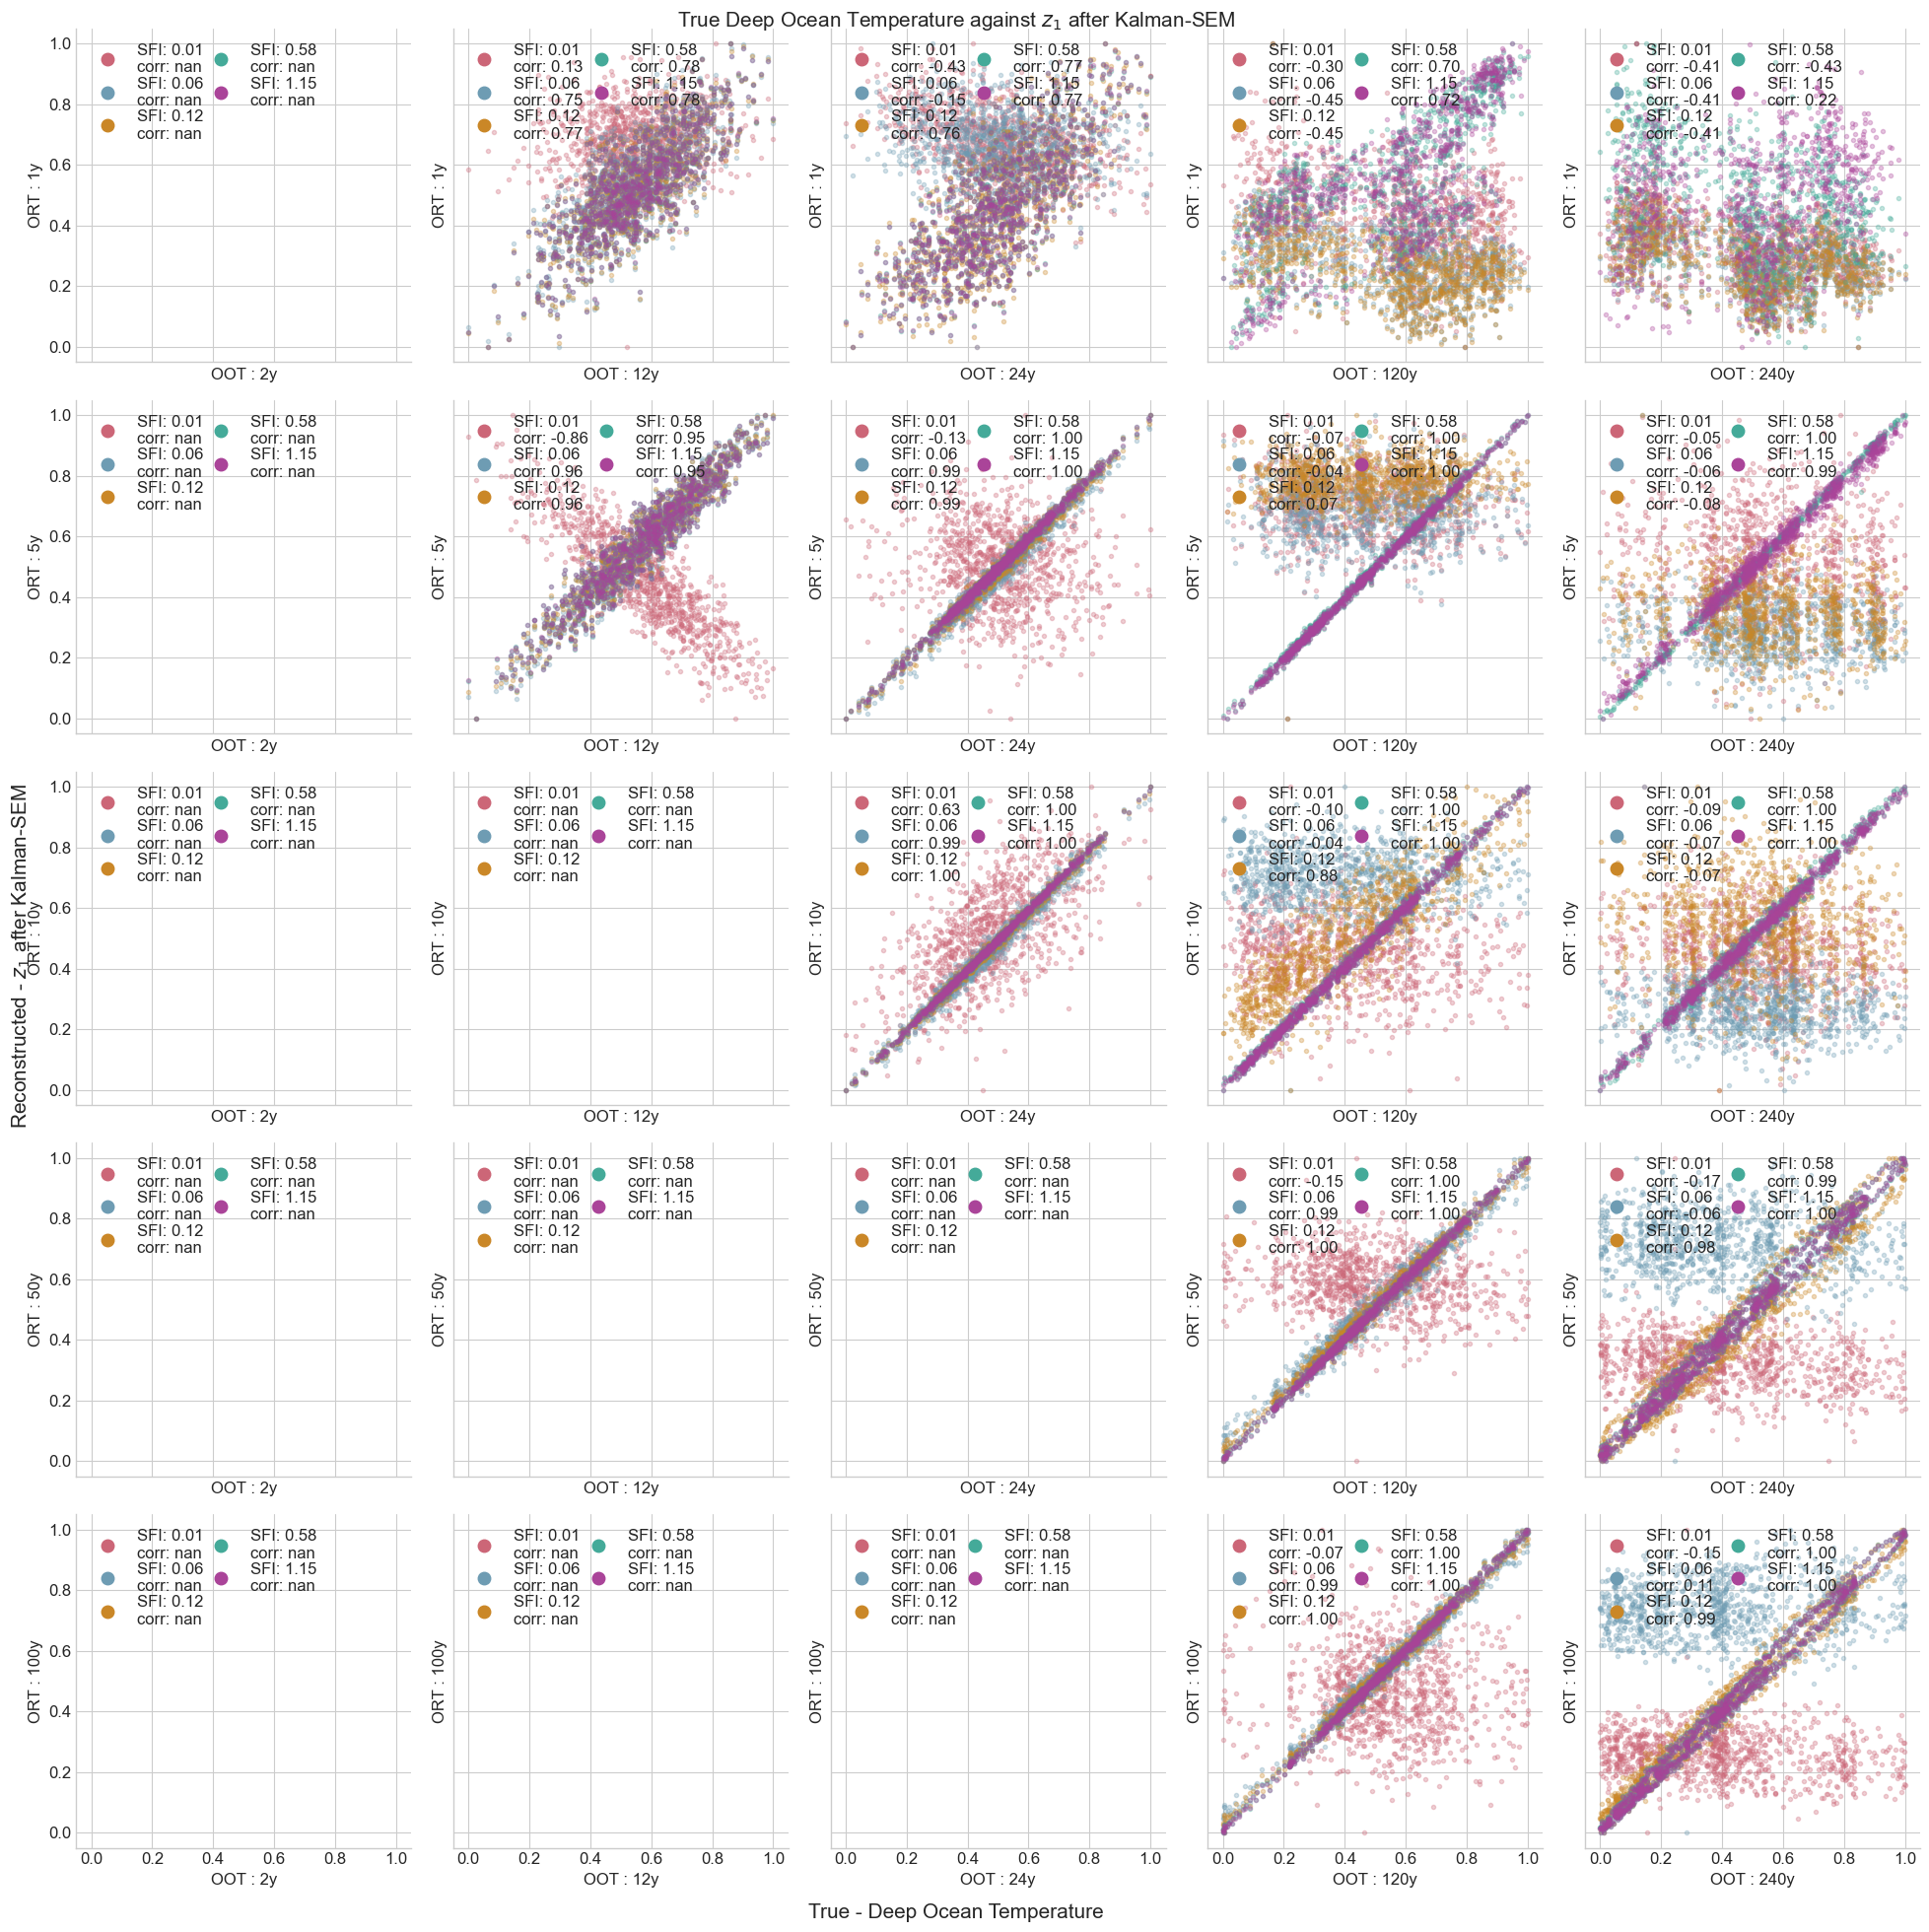

In [24]:
kwargs = dict(
    linewidth=None,
    linestyle="",
    alpha=0.3,
    marker=".",
)


x_labels = data_kalman_oscillator.ocean_oscillation_timescale.values
y_labels = data_kalman_oscillator.ocean_restoring_timescale.values
color_labels = data_kalman_oscillator.stochastic_forcing_intensity.values



fig, axs = plt.subplots(ncols=len(x_labels), nrows=len(y_labels), figsize=(20, 20), sharey=True, sharex=True)
for x_idx, x_value in enumerate(x_labels) :
    for y_idx, y_value in enumerate(y_labels) :
        for c_value in color_labels :
            sub = dict(
                ocean_oscillation_timescale = x_value,
                ocean_restoring_timescale = y_value,
                stochastic_forcing_intensity = c_value,
            )
            axs[y_idx, x_idx].plot(
                norm(data_exp.oscillator_deep_ocean_temperature.sel(sub)), 
                norm(data_kalman_oscillator.kalman_state_random_variable.sel(sub)),
                label = f"SFI: {c_value:.2f}\ncorr: {data_kalman_oscillator.correlation_coef.sel(sub).values:.2f}", 
                **kwargs,
            )
        # axs[y_idx, x_idx].set_title(f"OOT: {x_labels[idx] / 365.25:.0f}y" + f"\nORT: {y_labels[idx] / 365.25:.0f}y")
        axs[y_idx, x_idx].set_xlabel(f"OOT : {x_labels[x_idx] / 365.25:.0f}y")
        axs[y_idx, x_idx].set_ylabel(f"ORT : {y_labels[y_idx] / 365.25:.0f}y")
        
# for idx in range(len(axs)) :
#     axs[-1, idx].set_xlabel(f"OOT : {x_labels[idx] / 365.25:.0f}y")
#     axs[idx, 0].set_ylabel(f"ORT : {y_labels[idx] / 365.25:.0f}y")

def update(handle, orig):
    # https://stackoverflow.com/a/59629242/16372843
    handle.update_from(orig)
    handle.set_alpha(1)

for ax in axs.flatten() :
    ax.legend(
        loc="upper left",
        ncol=2, 
        markerfirst=True,
        markerscale = 3,
        scatterpoints = 1,
        labelspacing = 0.07,
        columnspacing = 0.07,
        handler_map={PathCollection : HandlerPathCollection(update_func= update),
                        plt.Line2D : HandlerLine2D(update_func = update)}
        )
fig.suptitle(r"True Deep Ocean Temperature against $z_1$ after Kalman-SEM")
fig.supxlabel("True - Deep Ocean Temperature")
fig.supylabel("Reconstructed - $z_1$ after Kalman-SEM")
fig.tight_layout()
fig.savefig("Experiments_correlation_norm_minmax.png", dpi = 400)

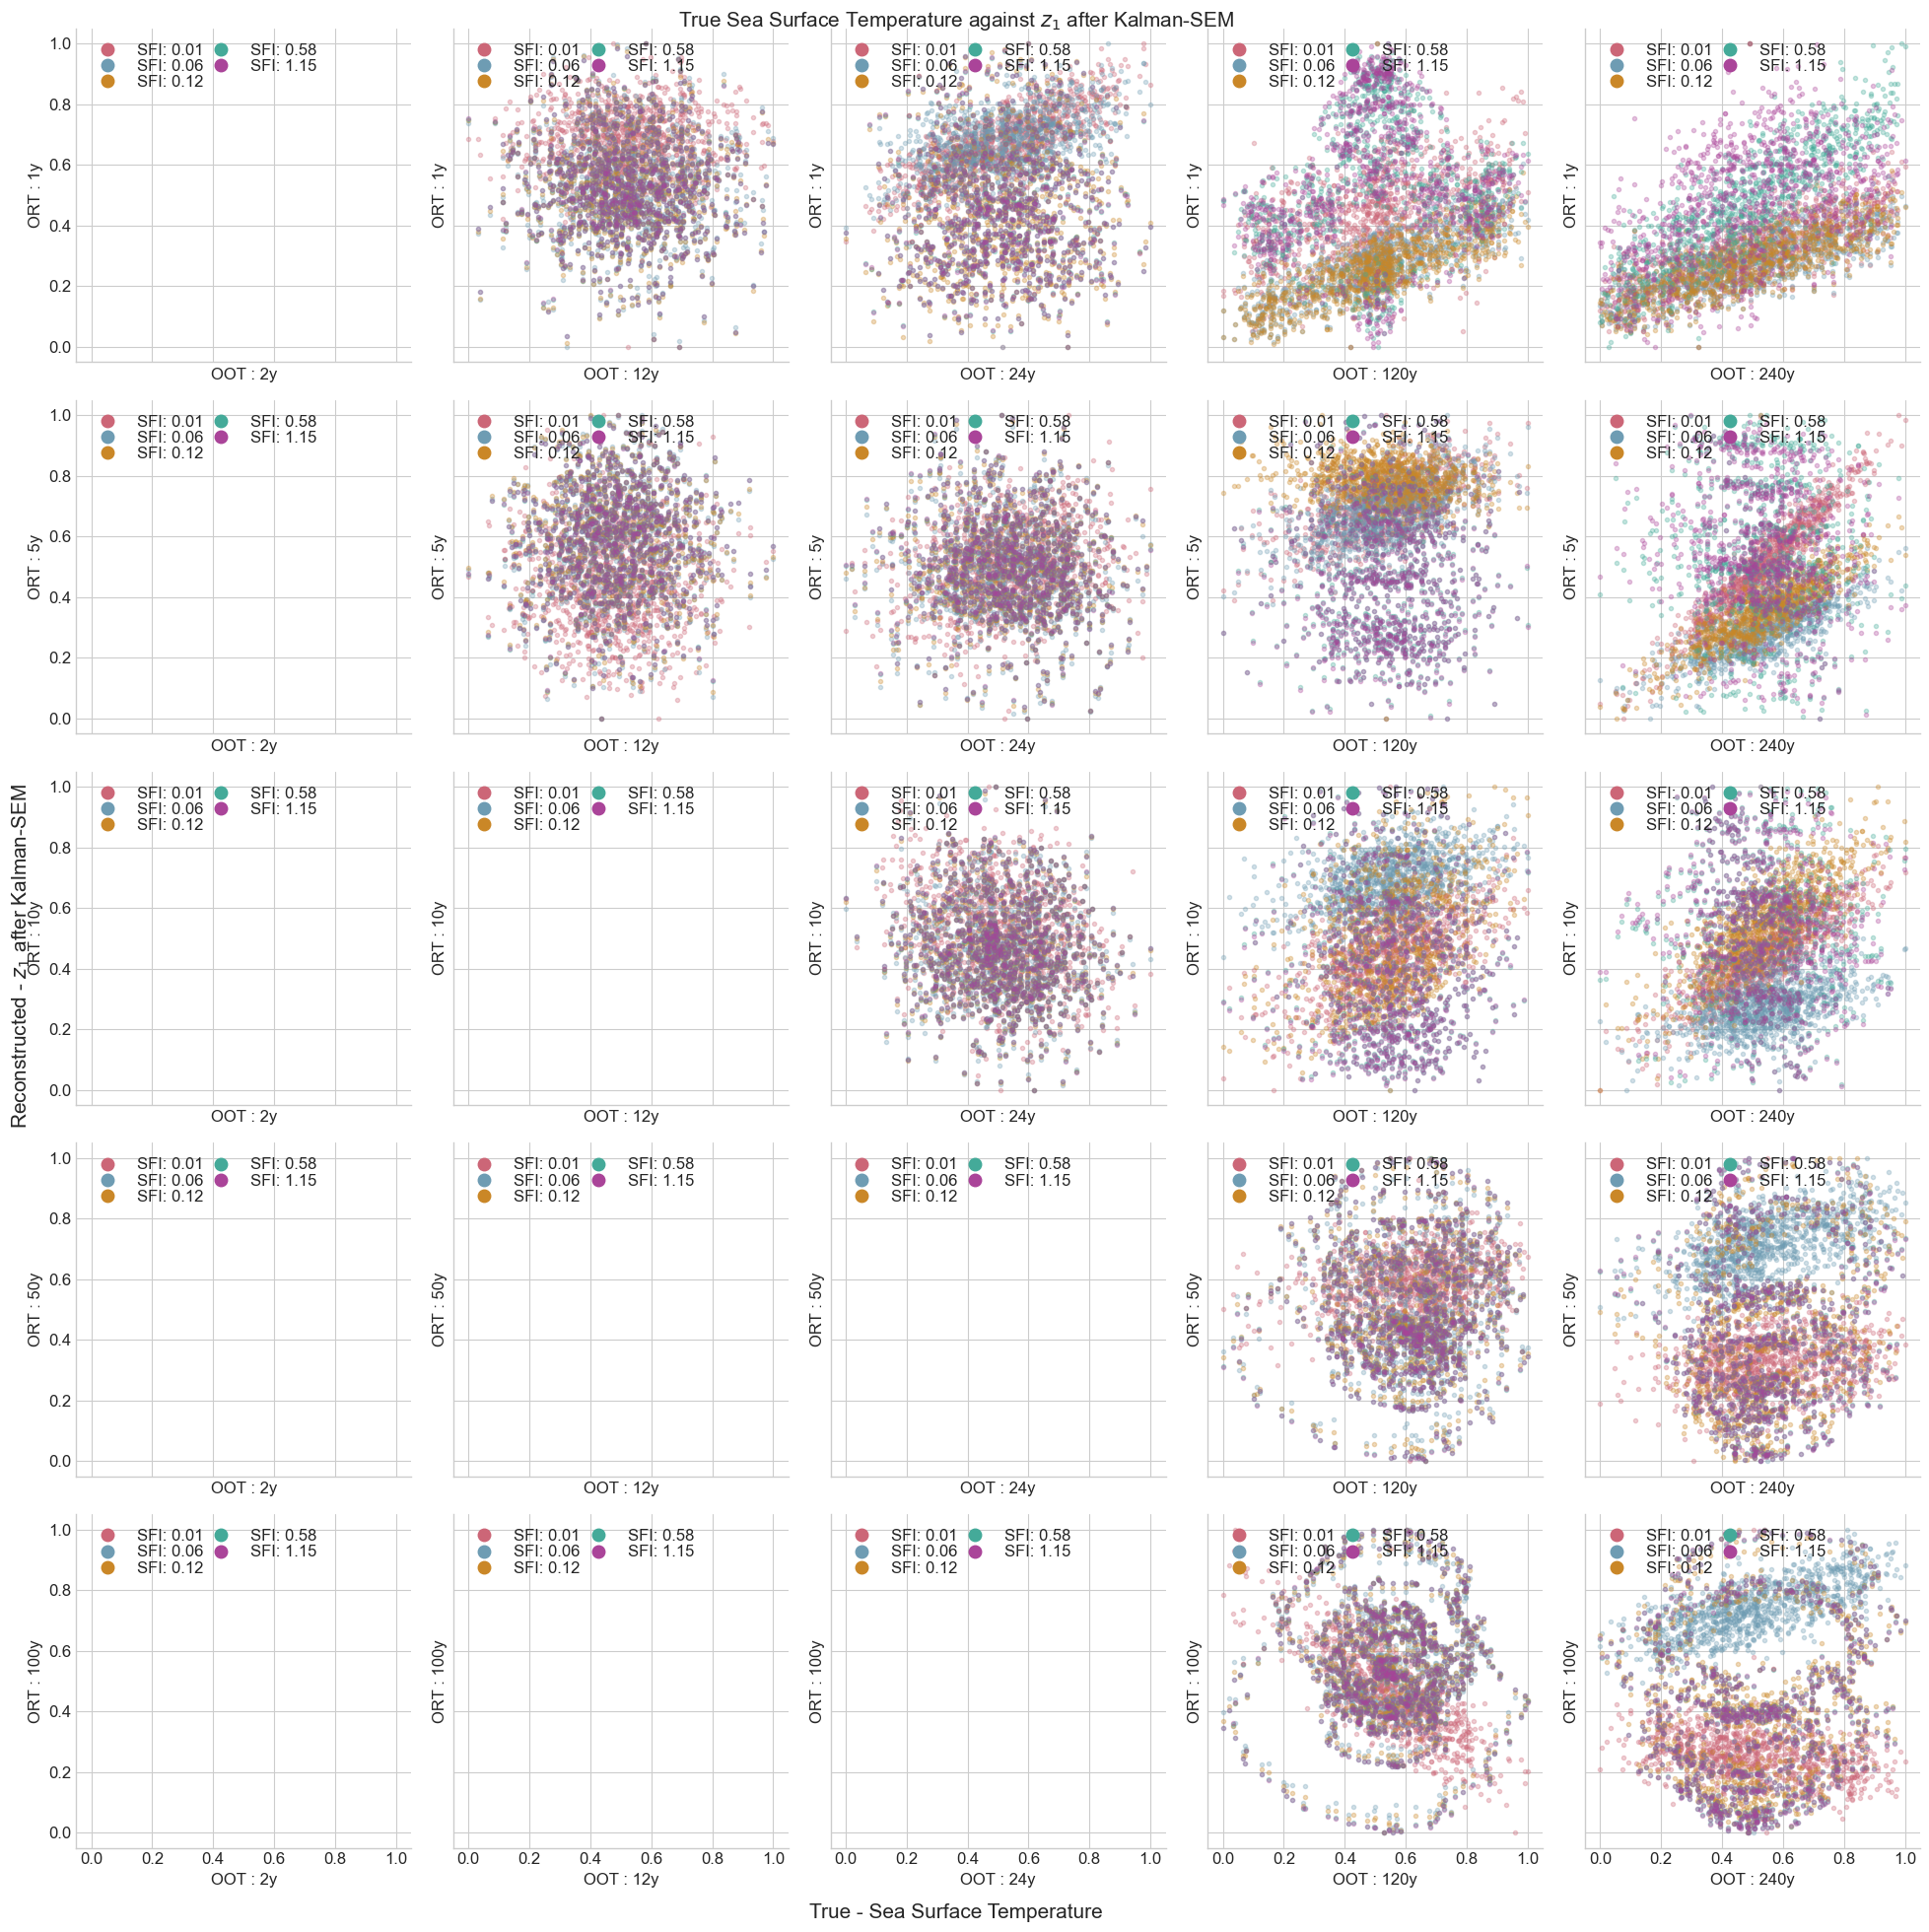

In [25]:
kwargs = dict(
    linewidth=None,
    linestyle="",
    alpha=0.3,
    marker=".",
)


x_labels = data_kalman_oscillator.ocean_oscillation_timescale.values
y_labels = data_kalman_oscillator.ocean_restoring_timescale.values
color_labels = data_kalman_oscillator.stochastic_forcing_intensity.values



fig2, axs = plt.subplots(ncols=len(x_labels), nrows=len(y_labels), figsize=(20, 20), sharey=True, sharex=True)
for x_idx, x_value in enumerate(x_labels) :
    for y_idx, y_value in enumerate(y_labels) :
        for c_value in color_labels :
            sub = dict(
                ocean_oscillation_timescale = x_value,
                ocean_restoring_timescale = y_value,
                stochastic_forcing_intensity = c_value,
            )
            axs[y_idx, x_idx].plot(
                norm(data_exp.oscillator_sea_surface_temperature.sel(sub)), 
                norm(data_kalman_oscillator.kalman_state_random_variable.sel(sub)),
                label = f"SFI: {c_value:.2f}", 
                **kwargs,
            )
        # axs[y_idx, x_idx].set_title(f"OOT: {x_labels[idx] / 365.25:.0f}y" + f"\nORT: {y_labels[idx] / 365.25:.0f}y")
        axs[y_idx, x_idx].set_xlabel(f"OOT : {x_labels[x_idx] / 365.25:.0f}y")
        axs[y_idx, x_idx].set_ylabel(f"ORT : {y_labels[y_idx] / 365.25:.0f}y")
        
# for idx in range(len(axs)) :
#     axs[-1, idx].set_xlabel(f"OOT : {x_labels[idx] / 365.25:.0f}y")
#     axs[idx, 0].set_ylabel(f"ORT : {y_labels[idx] / 365.25:.0f}y")

def update(handle, orig):
    # https://stackoverflow.com/a/59629242/16372843
    handle.update_from(orig)
    handle.set_alpha(1)

for ax in axs.flatten() :
    ax.legend(
        loc="upper left",
        ncol=2, 
        markerfirst=True,
        markerscale = 3,
        scatterpoints = 1,
        labelspacing = 0.07,
        columnspacing = 0.07,
        handler_map={PathCollection : HandlerPathCollection(update_func= update),
                        plt.Line2D : HandlerLine2D(update_func = update)}
        )
fig2.suptitle(r"True Sea Surface Temperature against $z_1$ after Kalman-SEM")
fig2.supxlabel("True - Sea Surface Temperature")
fig2.supylabel("Reconstructed - $z_1$ after Kalman-SEM")
fig2.tight_layout()
fig2.savefig("Experiments_oscilltion_norm_minmax.png", dpi = 400)

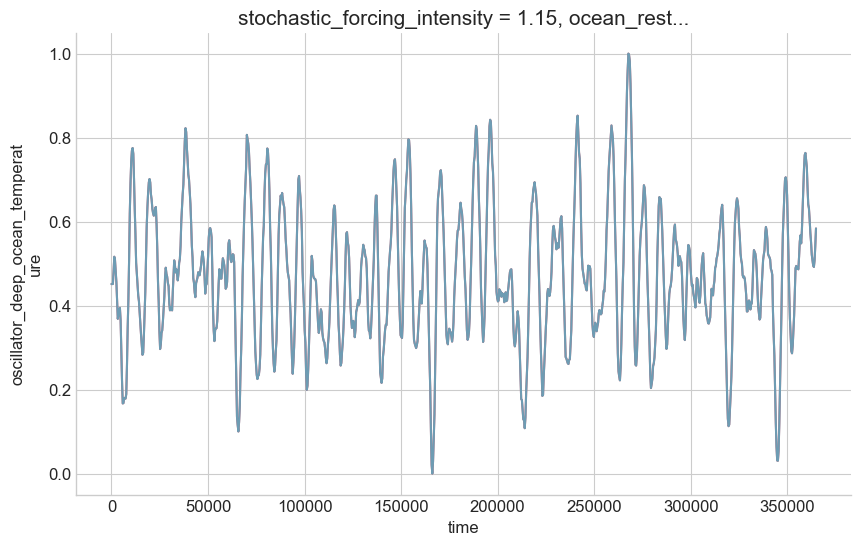

In [30]:
norm(data_exp.oscillator_deep_ocean_temperature.isel(
    dict(
        stochastic_forcing_intensity = 0,
        ocean_restoring_timescale = 2,
        ocean_oscillation_timescale = 2,
    )
)).plot()
norm(data_exp.oscillator_deep_ocean_temperature.isel(
    dict(
        stochastic_forcing_intensity = -1,
        ocean_restoring_timescale = 2,
        ocean_oscillation_timescale = 2,
    )
)).plot()